# Pneumonia Detection From X-Ray Images Using CNN

## Objective
Identify which patients have pneumonia based on chest x-ray images

------
## Settings

### Libraries

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
from tensorflow.keras.models import Sequential 
import math

### Data

In [6]:
path = Path("../data")
print([x.name for x in path.iterdir()])
print([x.name for x in Path(path / "train").iterdir()])

['train', 'test', 'val']
['pneumonia', 'normal']


In [35]:
sample_size = [
    {'Group': 'Train', 'Diagnostic': 'Normal', 'Number of images': len(list(Path(path / "train" / "normal").glob('*.jpeg')))},
    {'Group': 'Train', 'Diagnostic': 'Pneumonia', 'Number of images': len(list(Path(path / "train" / "pneumonia").glob('*.jpeg')))},
    {'Group': 'Validation', 'Diagnostic': 'Normal', 'Number of images': len(list(Path(path / "val" / "normal").glob('*.jpeg')))},
    {'Group': 'Validation', 'Diagnostic': 'Pneumonia', 'Number of images': len(list(Path(path / "val" / "pneumonia").glob('*.jpeg')))},
    {'Group': 'Test', 'Diagnostic': 'Normal', 'Number of images': len(list(Path(path / "test" / "normal").glob('*.jpeg')))},
    {'Group': 'Test', 'Diagnostic': 'Pneumonia', 'Number of images': len(list(Path(path / "test" / "pneumonia").glob('*.jpeg')))},
]
sample_size = pd.DataFrame(sample_size).pivot(index = 'Group', columns = 'Diagnostic', values = 'Number of images')
sample_size

Diagnostic,Normal,Pneumonia
Group,,
Test,234,390
Train,1341,3875
Validation,8,8


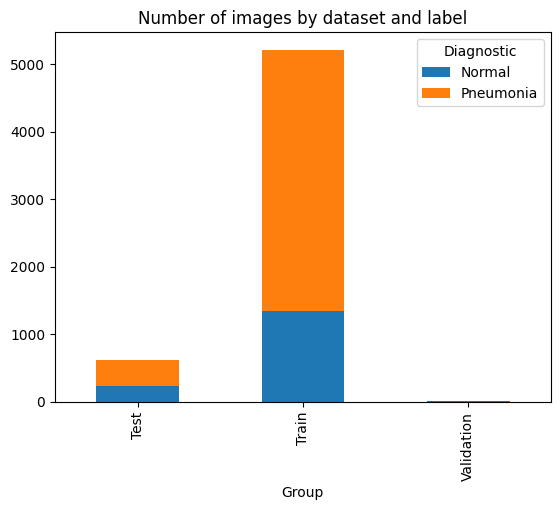

In [38]:
sample_size.plot.bar(stacked = True)
plt.title('Number of images by dataset and label')
plt.show()

In [7]:
X_train_normal = [cv.imread(x.as_posix(), cv.IMREAD_GRAYSCALE) for x in Path(path / "train" / "normal").iterdir()]

In [8]:
X_train_normal = [img for img in X_train_normal if img is not None]

### Explotary Data Analysis

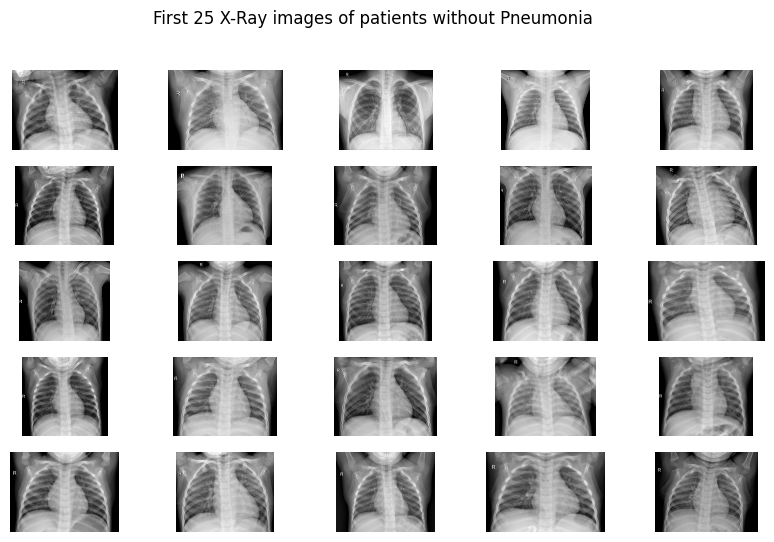

In [9]:
fig, axs = plt.subplots(5, 5)
i = 0
for row in axs:
    for ax in row:
        img = X_train_normal[i]
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        i += 1
fig.suptitle("First 25 X-Ray images of patients without Pneumonia")
fig.set_size_inches(10, 6)
fig.show()

In [10]:
dimensions = pd.DataFrame([img.shape for img in X_train_normal], columns = ["height", "width"])
dimensions.head()

,height,width
0,1082,1438
1,1496,2148
2,1672,1955
3,1936,2156
4,1433,1666


In [11]:
max_width = dimensions.width.max()
max_height = dimensions.height.max()
print(f"The maximum dimensions in the training set are:")
print(f"Max height: {max_height}")
print(f"Max width: {max_width}")

The maximum dimensions in the training set are:
Max height: 2663
Max width: 2916


### Preprocessing

The images need to have the same size for us to train and use a Convolutional Neural Network to clasify them. We will follow the recommendations of [this research paper](https://www.researchgate.net/publication/337260457_Enlarging_smaller_images_before_inputting_into_convolutional_neural_network_zero-padding_vs_interpolation), and add zero padding to make all images the same size as the largest image in the training data.

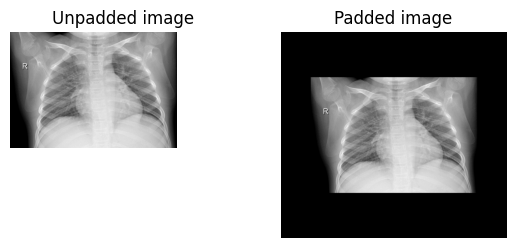

In [12]:
unpadded_img = X_train_normal[1]
horizontal_padding = (max_width - unpadded_img.shape[1]) / 2
vertical_padding = (max_height - unpadded_img.shape[0]) / 2
padded_img = cv.copyMakeBorder(
    unpadded_img,
    top = math.ceil(vertical_padding),
    bottom = math.floor(vertical_padding),
    left = math.ceil(horizontal_padding),
    right = math.floor(horizontal_padding),
    borderType = cv.BORDER_CONSTANT,
    value = 0 
)
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True)
axs[0].imshow(unpadded_img, cmap = "gray")
axs[0].set_title("Unpadded image")
axs[0].set_axis_off()
axs[1].imshow(padded_img, cmap = "gray")
axs[1].set_title("Padded image")
axs[1].set_axis_off()
plt.show()

### Model Pipeline

Because there are too many images to be loaded into memory, we will need to build an input pipeline to read and preprocess batches of images, and train the Convolutional Neural Network with each subsequent batch.